In [1]:
print("Importing...")
from GCN import *
from datetime import datetime
from utils.my_utils import *
from utils.util import *
import time
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import os
import math
from train_utils import *

torch.manual_seed(124)
np.random.seed(124)
print("Done importing")

Importing...


/home/sjj/micromamba/envs/torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done importing


In [2]:
print("Settings")

run_folder="../"
dataset = "data/Traceparts-dataset"
STEP_dataset= dataset + "/STEP_models/"
graphml_dataset = dataset + "/Graphml_Models/"
learning_rate=0.0005
batch_size=1
num_epochs=50
dropout=0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("The calculations will be performed on the device:", device)

# save paths
model_name = "GCN_" + str(datetime.today().strftime('%m-%d'))
# model_name = dataset + "_" + str(datetime.today().strftime('%m-%d'))
out_dir = os.path.abspath(os.path.join(run_folder, "./results/runs_GCN", dataset))
if not os.path.exists(out_dir + "/Models/"):
    os.makedirs(out_dir + "/Models/")
save_path = out_dir + "/Models/" + model_name
print("Results will be saved in:", out_dir)
print("    The model will be saved as:", save_path)

Settings
The calculations will be performed on the device: cuda:0
Results will be saved in: /home/sjj/wa/AI-projects/agentic-eda/3D_STEP_Classification/results/runs_GCN/data/Traceparts-dataset
    The model will be saved as: /home/sjj/wa/AI-projects/agentic-eda/3D_STEP_Classification/results/runs_GCN/data/Traceparts-dataset/Models/GCN_10-06


### CONVERT STEP 3D Models to GRAPHS
To convert STEP models into Graphml data we use the **make_graphh_dataset** Python scripts. It generates an indirect graph from each STEP file.
The function takes two input: 1) the path of the STEP dataset and 2) the output directory where it's gonna write the graph dataset.
To avoid generating each graphs every run, the graph are saved as a **.graphml** format and then reload at subsequent runs.

In [4]:
from Graph_convertion.step_2_graph import make_graphh_dataset

print("Converting STEP dataset in Graphml dataset")
make_graphh_dataset(os.path.abspath(os.path.join(run_folder,"Datasets",STEP_dataset)), os.path.abspath(os.path.join(run_folder,"Datasets",graphml_dataset)))
print("Done converting")

Converting STEP dataset in Graphml dataset


FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: 'C:\\Users\\mande\\Desktop\\3D_STEP_Classification-main\\Datasets\\Traceparts_6\\STEP_models/'

### We load the graph dataset
The list of all graph is loaded and divided in train, test and validation set

In [16]:
graphml_dataset

'Traceparts_6/'

In [3]:
import os
graphml_dataset = "/home/sjj/wa/AI-projects/agentic-eda/3D_STEP_Classification/data/Traceparts-dataset/Graphml_models/"

os.listdir(graphml_dataset)

['3', '4', '1', '0', '2', '5']

In [4]:
print("Loading Graph data...")
use_degree_as_tag = False
fold = 0
graphs, num_classes = my_load_data(graphml_dataset, use_degree_as_tag)


Loading Graph data...
Loading class: 3
Loading class: 4
Loading class: 1
Loading class: 0
Loading class: 2
Loading class: 5
# classes: 6
# maximum node tag: 80
# data: 600


In [21]:
len(graphs)

600

In [29]:
g0 = graphs[0]
len(g0.g.nodes), len(g0.g.edges)

(3887, 4639)

In [5]:

train_graphs, test_graphs = separate_data(graphs, fold)
train_graphs, valid_graphs = split_data(train_graphs, perc=0.9)
print("# training graphs: ", len(train_graphs))
print_data_commposition(train_graphs)
print("# validation graphs: ", len(valid_graphs))
print_data_commposition(valid_graphs)
print("# test graphs: ", len(test_graphs))
print_data_commposition(test_graphs)
# Num of different STEP entities founded in the graph dataset
feature_dim_size = graphs[0].node_features.shape[1]
print("Loading data... finished!")

# training graphs:  486
class: 0  - num elements: 81  - elements:  ['3_57.graphml.xml', '3_40.graphml.xml', '3_7.graphml.xml', '3_4.graphml.xml', '3_10.graphml.xml', '3_30.graphml.xml', '3_15.graphml.xml', '3_5.graphml.xml', '3_41.graphml.xml', '3_22.graphml.xml', '3_29.graphml.xml', '3_70.graphml.xml', '3_90.graphml.xml', '3_59.graphml.xml', '3_19.graphml.xml', '3_13.graphml.xml', '3_61.graphml.xml', '3_69.graphml.xml', '3_53.graphml.xml', '3_86.graphml.xml', '3_45.graphml.xml', '3_96.graphml.xml', '3_68.graphml.xml', '3_6.graphml.xml', '3_97.graphml.xml', '3_9.graphml.xml', '3_63.graphml.xml', '3_54.graphml.xml', '3_25.graphml.xml', '3_2.graphml.xml', '3_3.graphml.xml', '3_1.graphml.xml', '3_74.graphml.xml', '3_31.graphml.xml', '3_18.graphml.xml', '3_91.graphml.xml', '3_83.graphml.xml', '3_82.graphml.xml', '3_42.graphml.xml', '3_26.graphml.xml', '3_67.graphml.xml', '3_94.graphml.xml', '3_56.graphml.xml', '3_102.graphml.xml', '3_47.graphml.xml', '3_27.graphml.xml', '3_23.graphml.xml',

In [6]:
valid_graphs[0].node_features

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3820, 80), dtype=float32)

In [7]:
valid_graphs[0].edge_mat

array([[   0,    1,    2, ..., 3817, 3818, 3819],
       [   9,    9,   10, ..., 3402, 3404, 3406]],
      shape=(2, 9126), dtype=int32)

In [11]:
g0 = valid_graphs[0]

### Model
We create a Graph Convolutional Neural Network model: the convolutional layers are followed by an attention mechanism and finally by fully connected layers.

In [17]:
print("Creating model")

# Create a GCN model
model = GCN_CN_v4(feature_dim_size=feature_dim_size, num_classes=num_classes, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_batches_per_epoch = int((len(train_graphs) - 1) / batch_size) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_batches_per_epoch, gamma=0.1)

Creating model


In [18]:
print("Main process")

print("Writing to {}\n".format(out_dir))
# Checkpoint directory
checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
write_acc = open(checkpoint_prefix + '_acc.txt', 'w')

train_losses = []
train_accuracy = []
valid_losses = []
valid_accuracy = []
valid_accuracy_x_class = []

best_loss = math.inf
best_accuracy = 0
# Train loop
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # train model
    train(mmodel=model, optimizer=optimizer, train_graphs=train_graphs, batch_size=batch_size, num_classes=num_classes, device=device)
    # evaluate on train data
    train_loss, train_acc, _ = evaluate(mmodel=model, current_graphs=train_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)
    # evaluate on validation data
    valid_loss, valid_acc, valid_acc_x_class = evaluate(mmodel=model, current_graphs=valid_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)
    print('| epoch {:3d} | time: {:5.2f}s | train loss {:5.2f} | valid loss {:5.2f} | valid acc {:5.2f} | '.format(epoch, (time.time() - epoch_start_time), train_loss, valid_loss, valid_acc*100))

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracy.append(valid_acc)
    valid_accuracy_x_class.append(valid_acc_x_class)

    # Make a step of the optimizer if the mean of the last 6 epochs were better than the current epoch
    if epoch > 5 and train_losses[-1] > np.mean(train_losses[-6:-1]):
        scheduler.step()
        print("Scheduler step")
    # save if best performance ever
    if best_accuracy < valid_acc or (best_accuracy == valid_acc and best_loss > valid_loss):
        print("Save at epoch: {:3d} at valid loss: {:5.2f} and valid accuracy: {:5.2f}".format(epoch, valid_loss, valid_acc*100))
        best_accuracy = valid_acc
        best_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    write_acc.write('epoch ' + str(epoch) + ' fold ' + str(fold) + ' acc ' + str(valid_acc*100) + '%\n')

print("Finished training")

Main process
Writing to C:\Users\mande\Desktop\Erasmus\ComputerSecurity\3D_STEP_classification\results\runs_GCN\Test_dataset

| epoch   1 | time:  0.35s | train loss  0.53 | valid loss  0.57 | valid acc 100.00 | 
Save at epoch:   1 at valid loss:  0.57 and valid accuracy: 100.00


Plot results
Accuracy per class :
[100. 100.]


KeyboardInterrupt: 

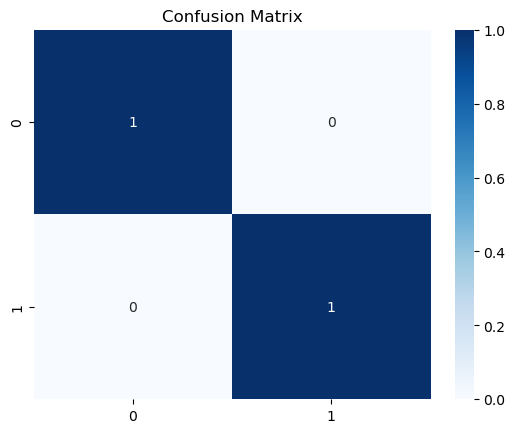

In [20]:
print("Plot results")

valid_accuracy_x_class = np.array(valid_accuracy_x_class).T
# plot training flow
plot_training_flow(ys=[train_losses, valid_losses], names=["train", "validation"], path=out_dir, fig_name="/losses_flow", y_axis="Loss")
plot_training_flow(ys=[np.array(train_accuracy)*100, np.array(valid_accuracy)*100], names=["train","validation"], path=out_dir, fig_name="/accuracy_flow", y_axis="Accuracy")
# Evaluate on test data
model.load_state_dict(torch.load(save_path))
test_loss, test_acc, _ = evaluate(mmodel=model, current_graphs=test_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir, last_round=True)
print("Evaluate: loss on test: ", test_loss, " and accuracy: ", test_acc * 100)

write_acc.close()

In [8]:
model_dict = torch.load("/home/sjj/wa/AI-projects/agentic-eda/3D_STEP_Classification/results/runs_GCN/data/Traceparts-dataset/Graphml_models/Models/GCN_10-06")

/tmp/ipykernel_1243780/1446043910.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load("/home/sjj/wa/AI-projects/agentic-eda/3D_STEP_Classification/re

In [9]:
model = GCN_CN_v4(feature_dim_size=feature_dim_size, num_classes=num_classes, dropout=dropout).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [33]:
model.eval()

GCN_CN_v4(
  (convolution_1): GCNConv(80, 64)
  (convolution_2): GCNConv(64, 32)
  (convolution_3): GCNConv(32, 32)
  (attention): AttentionModule()
  (fully_connected_first): Linear(in_features=32, out_features=32, bias=True)
  (scoring_layer): Linear(in_features=32, out_features=6, bias=True)
)

In [12]:
pred = model(torch.tensor(g0.edge_mat).to('cuda:0'), torch.tensor(g0.node_features).to('cuda:0'), return_embedding=True)

In [19]:
pred[0].cpu().detach().numpy()

array([-26.00376   ,   2.2028456 ,  -9.41914   , -21.043756  ,
         8.126876  , -30.60028   ,  -2.4081662 ,  -9.516182  ,
       -11.161637  , -22.480202  ,   7.908058  , -20.040874  ,
       -17.146297  ,   0.13706473, -46.761322  ,  -6.154416  ,
        16.599583  ,   9.561987  , -24.184782  ,  -3.6653612 ,
         2.2071419 , -16.021328  ,  -5.88104   , -19.661509  ,
        12.627158  , -10.318921  , -25.26075   ,  -1.4211298 ,
         0.6519666 ,  -4.2313027 , -11.871398  ,  -5.3171096 ],
      dtype=float32)

In [70]:
extractor = EmbeddingExtractor(model).to(device)
extractor.eval()

EmbeddingExtractor(
  (trained_model): GCN_CN_v4(
    (convolution_1): GCNConv(80, 64)
    (convolution_2): GCNConv(64, 32)
    (convolution_3): GCNConv(32, 32)
    (attention): AttentionModule()
    (fully_connected_first): Linear(in_features=32, out_features=32, bias=True)
    (scoring_layer): Linear(in_features=32, out_features=6, bias=True)
  )
  (encoder): Sequential(
    (0): GCNConv(80, 64)
    (1): GCNConv(64, 32)
    (2): GCNConv(32, 32)
    (3): AttentionModule()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [71]:
embeddings = extractor(torch.tensor(g0.edge_mat).to('cuda:0'),
    torch.tensor(g0.node_features).to('cuda:0'), )

TypeError: Sequential.forward() takes 2 positional arguments but 3 were given

In [63]:
embeddings

tensor([[-0.1023, -4.0029, -3.8720, -3.9381, -3.9978, -3.8983]],
       device='cuda:0')